**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree

**Load Data**

In [2]:
data = pd.read_csv('Diabetes.csv')
data.head()

,pregnant,glucose,BP,skin,insulin,BMI,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X = data.drop('label', axis=1)
y = data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

**Decision Tree - from Scratch**

In [4]:
#Implement the decision tree algorithm
def gini_index(groups, classes):
    n_instances = float(sum(len(group) for group in groups))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def get_best_split(data):
    class_values = list(set(row[-1] for row in data))
    best_index, best_value, best_score, best_groups = float('inf'), float('inf'), float('inf'), None
    for index in range(len(data[0]) - 1):
        for row in data:
            groups = split_data(index, row[index], data)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

def split_data(index, value, data):
    left, right = [], []
    for row in data:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y, depth=0):
        data = np.column_stack((X, y))
        if len(set(y)) == 1:
            return {'label': y[0]}

        if depth >= self.max_depth:
            return {'label': self.get_majority_class(y)}

        if len(data) == 0:
            return {'label': self.get_majority_class(y)}

        if len(set(y)) == 1:
            return {'label': y[0]}

        split = get_best_split(data)
        left_data, right_data = split['groups']

        if len(left_data) == 0 or len(right_data) == 0:
            return {'label': self.get_majority_class(y)}

        left = self.fit(np.array(left_data)[:, :-1], np.array(left_data)[:, -1], depth + 1)
        right = self.fit(np.array(right_data)[:, :-1], np.array(right_data)[:, -1], depth + 1)

        self.tree = {'index': split['index'], 'value': split['value'], 'left': left, 'right': right}
        return self.tree

    def get_majority_class(self, labels):
        unique_classes, class_counts = np.unique(labels, return_counts=True)
        majority_class = unique_classes[np.argmax(class_counts)]
        return majority_class

    def predict(self, X):
        predictions = []
        for sample in X:
            predictions.append(self.predict_single(sample, self.tree))
        return predictions

    def predict_single(self, sample, node):
        if 'label' in node:
            return node['label']

        if sample[node['index']] < node['value']:
            return self.predict_single(sample, node['left'])
        else:
            return self.predict_single(sample, node['right'])




In [5]:
decision_tree = DecisionTree(max_depth=5)
decision_tree.fit(X_train.values, y_train.values)


train_predictions = decision_tree.predict(X_train.values)
val_predictions = decision_tree.predict(X_val.values)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)



Train Accuracy: 0.8305400372439479
Validation Accuracy: 0.7532467532467533


In [6]:
def build_graph(node, dot, parent=None, edge_label=None):
    if "label" in node:
        dot.node(str(id(node)), str(node["label"]), shape="box")
        if parent is not None:
            dot.edge(str(id(parent)), str(id(node)), label=edge_label)
    else:
        dot.node(str(id(node)), "Feature " + str(node["index"]))
        if parent is not None:
            dot.edge(str(id(parent)), str(id(node)), label=edge_label)

        dot.node(str(id(node)) + "L", "Value < " + str(node["value"]))
        dot.node(str(id(node)) + "R", "Value >= " + str(node["value"]))
        dot.edge(str(id(node)), str(id(node)) + "L", label="True")
        dot.edge(str(id(node)), str(id(node)) + "R", label="False")
        
        build_graph(node["left"], dot, parent=node, edge_label="True")
        build_graph(node["right"], dot, parent=node, edge_label="False")


dot = graphviz.Digraph()
build_graph(decision_tree.tree, dot)
dot.render("decision_tree_scratch", format="pdf", cleanup=True)        

'decision_tree_scratch.pdf'

**Decision Tree - ready to use libraries**

Train Accuracy: 0.8324022346368715
Validation Accuracy: 0.7532467532467533


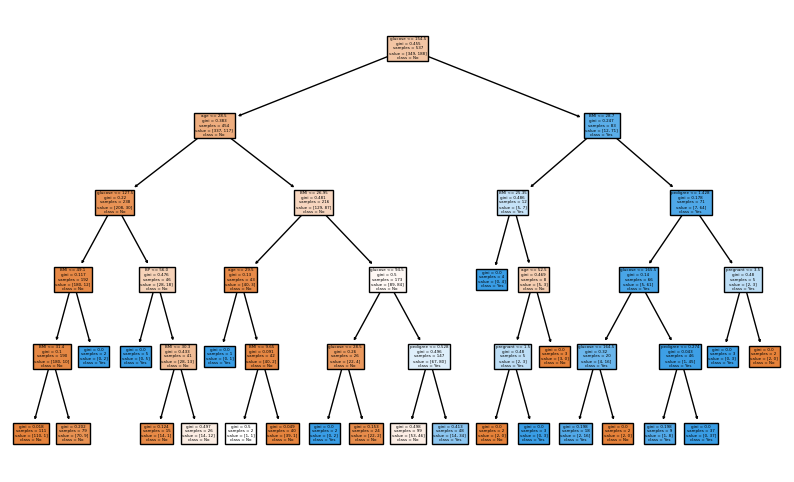

In [7]:
decision_tree = DecisionTreeClassifier(max_depth=5)

decision_tree.fit(X_train, y_train)

train_predictions = decision_tree.predict(X_train)
val_predictions = decision_tree.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

plt.figure(figsize=(10, 6))
plot_tree(decision_tree, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)
plt.savefig('decision_tree_library.pdf')
plt.show()

**Tree Max_depth =2**

In [8]:
######## scratch :
decision_tree = DecisionTree(max_depth=2)
decision_tree.fit(X_train.values, y_train.values)


train_predictions = decision_tree.predict(X_train.values)
val_predictions = decision_tree.predict(X_val.values)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Train Accuracy: 0.7597765363128491
Validation Accuracy: 0.7186147186147186


Train Accuracy: 0.7597765363128491
Validation Accuracy: 0.7186147186147186


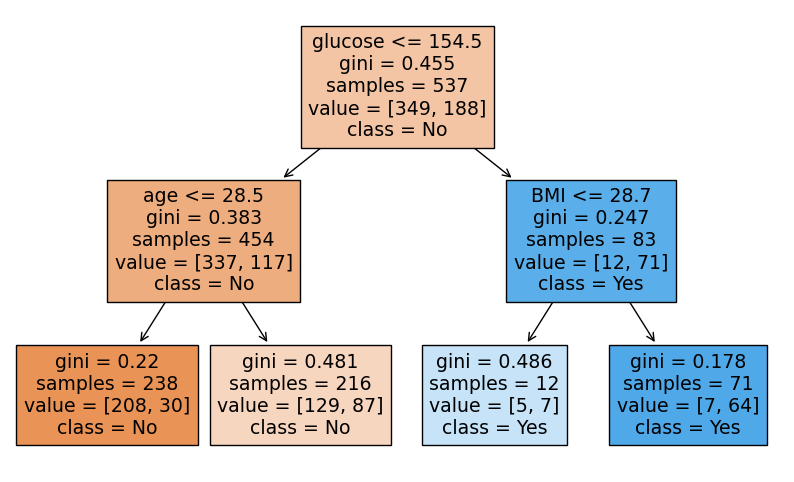

In [9]:
decision_tree = DecisionTreeClassifier(max_depth=2)

decision_tree.fit(X_train, y_train)

train_predictions = decision_tree.predict(X_train)
val_predictions = decision_tree.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

plt.figure(figsize=(10, 6))
plot_tree(decision_tree, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)
plt.savefig('decision_tree_library_depth2.pdf')
plt.show()